<h3><b>Algorytm KMeans opiera się o wyznaczenie centroidów minimalizujących odległość w klastrach(poszczególnych grupach obserwacji)</b></h3>
<hr/>
<b>Funkcja kosztu - czyli ta, którą należy minimalizować - w tym wypadku jest sumaryczną odległością pomiędzy punktami przynależącymi do klastra, a jego centroidem. Pierwiastek z kwadratu różnic może zostać pomnięty, ponieważ jest to funkcja monotoniczna rosnąca - wraz ze wzrostem argumentu, wartoć funkcji wzrasta</b>
<br />

$$D(c) = \sum_{i=1}^{n}(x_i - c)^2$$
$$gdzie\: n\: -\: ilosc\: obserwacji\: przypisanych\: do\: klastra\:, c\: -\: centroid\:, x_i\: -\: pojedyncza\: obserwacja\:$$

<hr/>
<br/>
<b>Poniżej pochodna funkcji kosztu(pozwalająca znaleźć jej ekstremum). Jest to funkcja kwadratowa, więc możemy spodziewać się jednego ekstremum, które będzie jej wartością minimalną.</b>
<br/>

$$D(c) = (x_1 - c)^2 + (x_2 - c)^2 + ... + (x_n - c)^2$$
$$D'(c) = -2(x_1 - c) + [-2(x_2 -c)^2] + ... + [-2(x_n - c)^2]$$
$$D'(c) = -2[(x_1 - c) + (x_2 - c) + ... + (x_n - c)]$$
$$D'(c) = -2[x_1 + x_2 + ... + x_n - nc]$$
$$D'(c) = -2(x_1 + x_2 + ... + x_n) + 2nc$$
$$D'(c) = 0\: (ekstremum)$$
$$0 = -2(x_1 + x_2 + ... + x_n) + 2nc$$
$$ c = \frac{1}{n}(x_1 + x_2 + ... + x_n)$$
<p><b>Oznacza to, że położenie centroidu powinno być wynikiem uśrednienia położenia punktów przynależących do konkretnych klastrów</b></p>
<hr/>
<br/>
<p><b>Algorytm KMeans opiera się więc o</b></p>
<p> 1. Obliczenie przynelażności do danych centroidów</p>
<p> 2. Centrowanie (wyżej wskazane uśrednianie)</p>
<p> 3. Powrót do punktu 1, jeśli nie zostało spełnione kryterium stopu (przykładowo - brak zmian w przypisanu do klastrów)</p>

In [298]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

class Data():
    def __init__(self, n_samples = 100, centers = 2, n_features = 2, random_state = 1):
        self._n_samples = n_samples
        self._centers = centers
        self._n_features = n_features
        self._random_state = random_state
        
    def load(self):
        self.X, self.y =\
            make_blobs(self._n_samples, self._centers, self._n_features, self._random_state)
        return self
    
    def _plot(self, centers = []):
        fig, ax = plt.subplots(figsize = (7, 5))
        sns.scatterplot(x = self.X[:, 0], y = self.X[:, 1], ax = ax)
        
        for c in centers:
            sns.scatterplot(x = c[:, 0], y = c[:, 1], ax = ax, s = 150)
            
        plt.show()


In [411]:
import random
import math

class KMeans():
    def __init__(self, centroids = 2, 
                 random_state = 1, init = "random", 
                 predefined_centroids = None):
        #init -> random/kmeans++/predefined
        self._centroids = centroids
        self._random_state = random_state
        self._init = init
        self._predefined_centroids = predefined_centroids
        self._cluster_centers = None
    
    def _random_center(self, data):
        #random.seed(self._random_state)
        index = random.randint(0, len(data.X))
        return index, data.X[index]
    
    def _distance(self, x1, x2):
        return sum([(xi - xj) ** 2 for xi, xj in zip(x1, x2)])
    
    def _distance_sqrt(self, x1, x2):
        return math.sqrt(self._distance(x1, x2))
    
    def _distance_to_centers(self, x, centers):
        return [self._distance_sqrt(c, x) for c in centers]
            
    def centroids(self, data):
        if self._cluster_centers is not None:
            raise Exception("Centroids already defined.")
        
        elif self._init == "predefined":
            if self._predefined_centroids is None:
                raise Exception("You have to set predefined_centroids.")
                
            self._cluster_centers = np.asarray(self._predefined_centroids)
            return self
        
        elif self._init == "random":
            self._cluster_centers = []
        
            cluster_centers = []    
            for _ in range(self._centroids):
                cluster_centers\
                    .append(self._random_center(data)[1])
            
            cluster_centers = np.asarray(cluster_centers)
            self._cluster_centers.append(cluster_centers)
            return self
        
        elif self._init == "kmeans++":
            self._cluster_centers = []
            
            index, random_center = self._random_center(data)
            cluster_centers = [random_center]
            cluster_centers_index = [index]
            
            for _ in range(self._centroids - 1):
                distances = np.asarray([(min(self._distance_to_centers(x, cluster_centers)), i) 
                                        for i, x in enumerate(data.X) 
                                        if i not in cluster_centers_index])
                
                distances[:, 0] = distances[:, 0] ** 2
                distances_sum = distances[:, 0].sum()
                distances[:, 0] = distances[:, 0] / distances_sum
                max_prob = distances[:, 0].max()
                
                center_index = int(distances[np.where( distances[:, 0] == max_prob )][0, 1])
                cluster_centers_index.append(center_index)
                cluster_centers.append(data.X[center_index])
            
            cluster_centers = np.asarray(cluster_centers)
            self._cluster_centers.append(cluster_centers)
            return self
        else:
            raise Exception("Init method not implemented.")
    
    def step(self, data):
        centers = self._cluster_centers[-1]
        
        distances = []
        for c in centers:
            distances.append([self._distance(c, x) for x in data.X])
        
        distances = np.asarray(distances).T
        clusters = np.argmin(distances, axis = 1)
        cluster_points = [[] for _ in range(self._centroids)]

        for i, c in enumerate(clusters):
            cluster_points[c].append(i)

        cluster_centers = []
        for cp in cluster_points:
            point = []
            for i in range(data.X.shape[1]):
                point.append(data.X[cp, i].sum() / len(cp))
            cluster_centers.append(point)
        
        cluster_centers = np.asarray(cluster_centers)
        self._cluster_centers\
            .append(cluster_centers)
        
        return self
          
    def plot(self, data):
        data._plot(self._cluster_centers)
            

In [412]:
data = Data(centers = 2, n_features = 3).load()
kmeans = KMeans(init = "random", centroids = 3)

In [413]:
kmeans = kmeans.centroids(data)

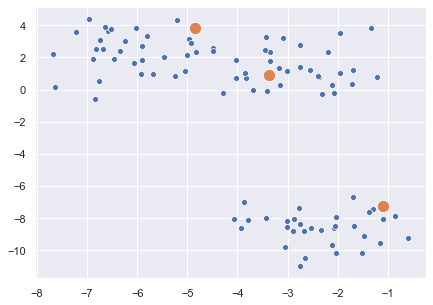

In [414]:
kmeans.plot(data)

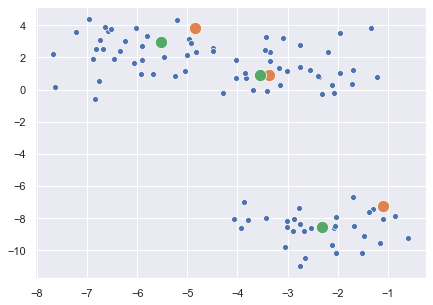

In [415]:
kmeans.step(data)
kmeans.plot(data)

<p><b>Punkty zielone są centroidami po jednym centorowaniu</b></p>
<p><b>Pomarańczowe - poprzednie centroidy</b></p>

<p><b>Trudność może sprawić określenie początkowych punktów centroidów - moga być one losowe, jednakże przy zastosowaniu algorytmu KMeans++ jesteśmy w stanie uzyskać lepsze wyniki</b></p>
$$Opiera\: sie\: on\: o:\: $$
$$1.\: Losowy\: wybor\: centroidu\: pierwszego$$
$$2\: Wybor\: srodka\: nastepnego\: klastra\: ze\: zbioru\: punktow\: x\: wg.\: wzoru\: \frac{D(x)^2}{\sum_{i = 1}^n D(x_i)^2}, gdzie\: n\: -\: liczebnosc\: zbioru\: x, D(x)\: -\: najkrotsza\: odleglosc\: do\: juz\: zdefiniowanego\: centoridu$$
$$3.\: Kontynujemy\: punkt\: 2\: az\: do\: uzyskania\: zdefiniowanej\: liczby\: centroidow\:$$
$$4.\: Centrowanie\: odbywa\: sie\: przy\: uzyciu\: standardowego\: algorytmu\: KMeans$$

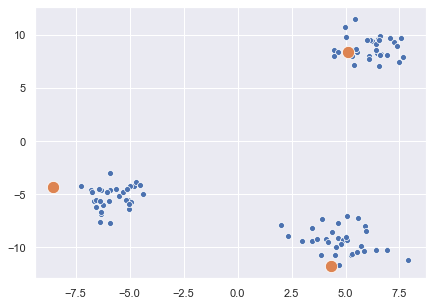

In [417]:
data = Data(centers = 2, n_features = 3).load()
kmeans = KMeans(init = "kmeans++", centroids = 3)
kmeans = kmeans.centroids(data)
kmeans.plot(data)

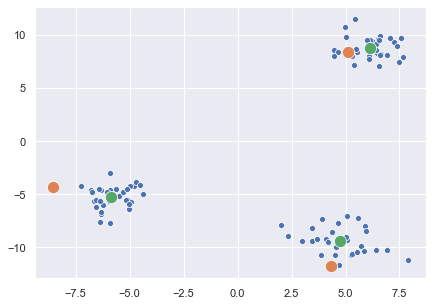

In [418]:
kmeans = kmeans.step(data)
kmeans.plot(data)